In [1]:
from functools import reduce
import pandas as pd 
import itertools as it
from brent import Query, DAG, SupposeQuery
from brent.common import make_fake_df

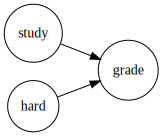

In [2]:
grade = ["good", "pass", "fail"]
study = ["lots", "little", "no"]
hard = ["yes", "no"]
probs = [0.6, 0.3, 0.1, 
         0.9, 0.09, 0.01, 
         0.3, 0.3, 0.4, 
         0.6, 0.2, 0.2, 
         0.1, 0.3, 0.6, 
         0.1, 0.5, 0.4]
zipprod = zip(it.product(study, hard, grade), probs)
tween = reduce(lambda a,b: a+b, [[c]*int(p * 100) for c, p in zipprod])
df = pd.DataFrame(tween, columns=["study", "hard", "grade"])
dag = (DAG(df)
       .add_edge("study", "grade")
       .add_edge("hard", "grade"))
dag.plot()

In [3]:
q = Query(dag).given(study="lots", grade="pass")
q.infer()

{'hard': {'no': 0.2307692307692308, 'yes': 0.7692307692307693},
 'study': {'lots': 1.0},
 'grade': {'pass': 1.0}}

In [4]:
p_not_hard, p_hard = q.infer()['hard']['no'], q.infer()['hard']['yes']

In [5]:
for studied in ['little', 'no']:
    v1 = 1 - Query(dag).given(hard="yes", study=studied).infer()['grade']['fail']
    v2 = 1 - Query(dag).given(hard="no", study=studied).infer()['grade']['fail']
    print(f"p(grade=pass|study={studied}, do(study=lots) -> grade=pass) = {v1*p_hard + v2*p_not_hard}")

p(grade=pass|study=little, do(study=lots) -> grade=pass) = 0.6461538461538462
p(grade=pass|study=no, do(study=lots) -> grade=pass) = 0.44615384615384623


# Jonatan and Vincent

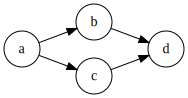

In [6]:
from brent.common import make_fake_df

df = make_fake_df(nodes=4, rows=100, values=2)
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "d").add_edge("b", "d")
dag.plot()

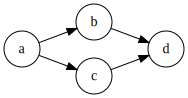

In [7]:
import random

def simulate_row():
    a = int(random.random() > 0.2)
    b_lim = 0.5 + 0.2 * a
    c_lim = 0.5 - 0.03 * a
    b = int(random.random() < b_lim)
    c = int(random.random() > c_lim)
    d_lim = 0.5 - 0.2*b - 0.1*c
    d = int(random.random() > d_lim)
    return a, b, c, d

df = pd.DataFrame([simulate_row() for _ in range(1_000_000)], columns=list("abcd"))
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "d").add_edge("b", "d")
dag.plot()

In [10]:
q = Query(dag=dag)
q.infer(give_table=True)

,a,c,b,d,prob
0,0,0,0,1,0.025035
1,0,0,0,0,0.024955
2,0,0,1,0,0.014991
3,0,0,1,1,0.035043
4,0,1,0,0,0.019979
5,0,1,0,1,0.030045
6,0,1,1,1,0.040023
7,0,1,1,0,0.010045
8,1,0,0,1,0.056437
9,1,0,0,0,0.056258


In [11]:
SupposeQuery(dag).when(q).infer(give_table=True)

,a,c,b,d,prob
0,0,0,0,1,0.005201
1,0,0,0,0,0.005168
2,0,0,1,0,0.001865
3,0,0,1,1,0.010191
4,0,1,0,0,0.003313
5,0,1,0,1,0.007492
6,0,1,1,1,0.013294
7,0,1,1,0,0.000837
8,1,0,0,1,0.026434
9,1,0,0,0,0.026266


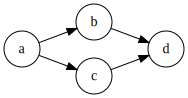

In [9]:
q = Query(dag=dag)
q.plot()

In [31]:
Query(dag=dag).infer(give_table=True)

,c,a,b,d,prob
0,0,0,0,0,0.024872
1,0,0,0,1,0.024771
2,0,0,1,1,0.034918
3,0,0,1,0,0.014995
4,0,1,0,0,0.056553
5,0,1,0,1,0.056322
6,0,1,1,1,0.183765
7,0,1,1,0,0.078917
8,1,0,0,1,0.030200
9,1,0,0,0,0.020017


In [17]:
Query(dag=dag).do(b=1).given(d=0).infer()

{'c': {0: 0.5007865149751212, 1: 0.49921348502487883},
 'a': {0: 0.5217667476434151, 1: 0.47823325235658487},
 'b': {1: 1.0},
 'd': {0: 1.0}}

In [18]:
s = SupposeQuery(dag).when(q).suppose_do(c=0)
s.infer()

{'c': {0: 0.4307782378534181, 1: 0.5692217621465819},
 'a': {0: 0.5583908597440495, 1: 0.44160914025595055},
 'b': {0: 1.0000000000000002},
 'd': {0: 0.4430088087725321, 1: 0.556991191227468}}

In [19]:
s = SupposeQuery(dag).when(q).suppose_do(b=0)
s.infer()

{'c': {0: 0.40922616412606017, 1: 0.5907738358739397},
 'a': {0: 0.5020524758498195, 1: 0.4979475241501804},
 'b': {0: 0.9999999999999998},
 'd': {0: 0.44085078386679255, 1: 0.5591492161332073}}